<a href="https://colab.research.google.com/github/EmanuelAlogna/MRI-generation/blob/master/src/MRI_generation_with_pix2pix(P2P_t2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [244]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)

TensorFlow is already loaded. Please restart the runtime to change versions.
2.0.0


In [0]:
!pip install -q -U tensorboard

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
def get_feature_description(modalities):                                                   
                                                                                           
    feature_description =lambda mod : {                                                    
                            mod+'_mri': tf.io.FixedLenFeature([], tf.string),              
                            mod+'_path': tf.io.FixedLenFeature([], tf.string),             
                                                                                           
                            mod+'_mri_min': tf.io.FixedLenFeature([], tf.float32),         
                            mod+'_mri_min_src': tf.io.FixedLenFeature([], tf.float32),     
                            mod+'_mri_max': tf.io.FixedLenFeature([], tf.float32),         
                            mod+'_mri_max_src': tf.io.FixedLenFeature([], tf.float32),     
                                                                                           
                            mod+'_mri_lperc': tf.io.FixedLenFeature([], tf.float32),       
                            mod+'_mri_hperc': tf.io.FixedLenFeature([], tf.float32),       
                            mod+'_mri_hperc_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_mri_lperc_src': tf.io.FixedLenFeature([], tf.float32),   
                                                                                           
                            mod+'_x_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_y_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_z_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_z_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                            mod+'_x_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                            mod+'_y_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                                                                                           
                            mod+'_x_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                            mod+'_y_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                            mod+'_z_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                                                                                           
                            mod+'_z_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_x_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_y_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                                                                                           
                            mod+'_patient': tf.io.FixedLenFeature([], tf.string),          
                            mod+'_sample_number': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_patient_grade': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_location': tf.io.FixedLenFeature([], tf.string),         
                            mod+'_dataset_version': tf.io.FixedLenFeature([], tf.string),  
                            mod+'_dataset_name': tf.io.FixedLenFeature([], tf.string),     
                            mod+'_mri_type': tf.io.FixedLenFeature([], tf.string),         
                            mod+'_dataset_split': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_patient_mri_seq': tf.io.FixedLenFeature([], tf.string),  
                          }                                                                
    features = {}                                                                          
    for mod in modalities:
        features.update(feature_description(mod))
    return features

In [0]:
use_gzip_compression = True

def load_dataset(name, mri_type, center_crop=None, random_crop=None, filter=None, batch_size=32, cache=True, 
                 prefetch_buffer=1, shuffle_buffer=128, interleave=1, cast_to=tf.float32, clip_labels_to=0.0, 
                 take_only=None, shuffle=True, infinite=False, n_threads=os.cpu_count()):
    def parse_sample(sample_proto):
        parsed = tf.io.parse_single_example(sample_proto, get_feature_description(["OT"]+mri_type))
        # Decoding image arrays
        
        slice_shape = [parsed['OT_x_dimension'.format(mri_type[0])], parsed['OT_y_dimension'], 1]
        # Decoding the ground truth
        parsed['seg'] = tf.cast(tf.reshape(tf.io.decode_raw(parsed['OT_mri'], tf.float32), shape=slice_shape), dtype=cast_to)
        # Decode each channel and stack in a 3d volume
        stacked_mri = list()
        for mod in mri_type:
            stacked_mri.append(tf.cast(tf.reshape(tf.io.decode_raw(parsed['{}_mri'.format(mod)], tf.float32), shape=slice_shape), dtype=cast_to))
        parsed['mri'] = tf.concat(stacked_mri, axis=-1)
        # Clipping the labels if requested
        parsed['seg'] = tf.clip_by_value(parsed['seg'], 0.0, clip_labels_to) if clip_labels_to else parsed['seg']
        
        # Cropping
        if random_crop or center_crop:
            # Stacking the mri and the label to align the crop shape
            mri_seg = tf.concat([parsed['mri'], parsed['seg']], axis=-1)
            if random_crop:
                random_crop[-1] = mri_seg.shape[-1] 
                cropped = tf.image.random_crop(mri_seg, size=random_crop)
            else:
                cropped = tf.image.resize_with_crop_or_pad(mri_seg,center_crop[0],center_crop[1])
            # Splitting back
            parsed['mri'] = cropped[:,:,:len(mri_type)]
            parsed['seg'] = cropped[:,:,len(mri_type):]
        
        return parsed
    
    path = './drive/My Drive/MRI-generation/{}.tfrecords'.format(name)
    dataset = tf.data.TFRecordDataset(path, compression_type='GZIP' if use_gzip_compression else "")
    dataset = dataset.filter(filter) if filter is not None else dataset
    dataset = dataset.take(take_only) if take_only is not None else dataset
    
    if shuffle and infinite:
        dataset = dataset.apply(tf.data.experimental.shuffle_and_repeat(shuffle_buffer))
    else:
        dataset = dataset.shuffle(shuffle_buffer, reshuffle_each_iteration=True) if shuffle else dataset
        dataset = dataset.repeat() if infinite else dataset
    dataset = dataset.map(parse_sample, num_parallel_calls=None)
    dataset = dataset.batch(batch_size) if batch_size > 0 else dataset
    dataset = dataset.cache() if cache else dataset

    if interleave > 1:
        dataset = dataset.interleave(lambda x: tf.data.Dataset.from_tensors(x).repeat(interleave), cycle_length=n_threads, block_length=interleave, num_parallel_calls=n_threads)
  
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [0]:
# loading all the dataset, with only modality T1 and T2

# I'll focus now on synthesizing T2 from T1

validation = load_dataset('brats2015_validation_crop_mri', ['MR_T1', 'MR_T2'])
training = load_dataset('brats2015_training_crop_mri', ['MR_T1', 'MR_T2'])
testing = load_dataset('brats2015_testing_crop_mri', ['MR_T1', 'MR_T2'])

Modalities: 


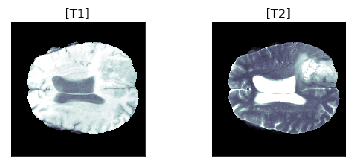

In [278]:
modalities = ['MR_T1_mri', 'MR_T2_mri']
index_batch = 21

for raw_record in validation.take(1):
    inp, re = np.empty(2)

    plt.figure(1 , figsize = (6 , 6))
    n = 0       
    print("Modalities: ")
    for idx,mod in enumerate(modalities):
        image = raw_record[mod].numpy()
        output = np.frombuffer(image[index_batch], dtype=np.float32)
        test = np.reshape(output, (180, 180))
        n += 1
        plt.subplot(1 , 2 , n)
        plt.imshow(test, cmap='bone')
        if idx == 0: 
            str = 'T1' 
            inp = test
        elif idx == 1: 
            str = 'T2'
            re = test
        plt.title('[{}]'.format(str))
        plt.xticks([]) , plt.yticks([])
        plt.subplots_adjust(hspace = 0.5, wspace = 0.5)

In [0]:
#BUFFER_SIZE = 400
#BATCH_SIZE = 1

IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 1

In [0]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [199]:
inp2 = np.expand_dims(inp, axis=2)
print(inp.shape, inp2.shape)

re2 = np.expand_dims(re, axis=2)
print(re.shape, re2.shape)


(180, 180) (180, 180, 1)
(180, 180) (180, 180, 1)


In [0]:
# this is just a test
down_model = downsample(64, 4)
down_result = down_model(tf.expand_dims(inp2, 0))
print (down_result.shape)

(1, 90, 90, 64)


In [0]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [201]:
up_model = upsample(512, 4, apply_dropout=True)
up_result = up_model(down_result)
print (up_result.shape)

(1, 180, 180, 512)


In [0]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [426]:
inp_resized, re_resized = resize(inp2, re2, 256, 256)
inp_resized.shape, re_resized.shape

(TensorShape([256, 256, 1]), TensorShape([256, 256, 1]))

In [0]:
print("T1 and T2 scans with shape = (256, 256, 1)\n")
plt.figure(1 , figsize = (6 , 6))
plt.subplot(1 , 2 , 1)
plt.imshow(np.squeeze(inp_resized), cmap='bone')
plt.title('[T1]')
plt.subplot(1 , 2 , 2)
plt.imshow(np.squeeze(re_resized), cmap='bone')
plt.title('[T2]')
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)

In [0]:
# hint from the web: Unfortunately, UNet does not work with arbitrary input sizes. Try ResNet instead.

def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 1)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)
  print(x.shape)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [208]:
generator = Generator()
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

(None, 256, 256, 1)


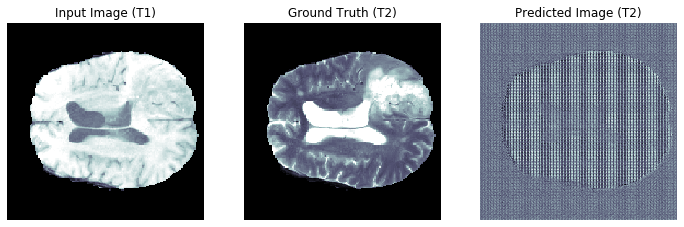

In [434]:
# with [tf.newaxis,...] I'm adding a new dimension to the image: from [256, 256, 1] to [1, 256, 256, 1]
gen_output = generator(inp_resized[tf.newaxis,...], training=False)

plt.figure(figsize=(12, 12))

display_list = [inp_resized, re_resized, gen_output]
title = ['Input Image (T1)', 'Ground Truth (T2)', 'Predicted Image (T2)']
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(np.squeeze(display_list[i]* 0.5 + 0.5), cmap='bone')
    plt.axis('off')
plt.show()

In [0]:
LAMBDA = 100

In [0]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [0]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [0]:
discriminator = Discriminator()
#tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [0]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [0]:
def generate_images(model, test_input, tar):
    prediction = model(test_input[tf.newaxis,...], training=True)

    # FROM STACKOVERFLOW:
    # Some neural network layers behave differently during training and inference, for example Dropout and BatchNorm
    # During training, dropout will randomly drop out units and correspondingly scale up activations of the remaining units.
    # During inference, it does nothing (since you usually don't want the randomness of dropping out units here).
    # The training argument lets the layer know which of the two "paths" it should take. 
    # If you set this incorrectly, your network might not behave as expected.

    display_list = [test_input, tar, prediction]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    plt.figure(1 , figsize = (12 , 12))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(np.squeeze(display_list[i]), cmap='bone')
        plt.axis('off')
    plt.show()

In [0]:
# GENERATION OF T2 from T1:
ground_truth
modalities = ['MR_T1_mri', 'MR_T2_mri']     # input and ground truth
index_batch = 31  # taking a random sample from the batch of 32 samples
numpy_input, numpy_gt = np.empty(2)

for raw_record in testing.take(1):
    numpy_input = raw_record[modalities[0]].numpy()
    numpy_gt = raw_record[modalities[1]].numpy()

    
    inp = np.reshape(np.frombuffer(numpy_input[index_batch], dtype=np.float32), (180, 180))
    ground_truth = np.reshape(np.frombuffer(numpy_gt[index_batch], dtype=np.float32), (180, 180))
    # shape is (180, 180)
    inp = np.expand_dims(inp, axis=2)
    ground_truth = np.expand_dims(ground_truth, axis=2)
    # the shape now is (180,180,1)  
    
    # I need to resize the input images in order to feed them to the U-net. 
    # With 128 I would decrease the resolution, so let's increase it to 256
    input_resized, ground_truth_resized = resize(inp, ground_truth, 256, 256)
    # the shape now is (256,256,1)
    generate_images(generator, input_resized, ground_truth_resized)

In [0]:
EPOCHS = 150